<a href="https://colab.research.google.com/github/Xiyao-Song/Xiyao-Song/blob/main/OSM%26Yelp_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [ ]:
!pip install openpyxl
!pip install openpyxl osmnx geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load Cleaned Yelp Data

In [ ]:
# 1. Load Yelp data
yelp_df = pd.read_csv("/content/drive/MyDrive/5400_Group1_Data/Cleaned_Yelp/yelp_master_clean.csv")

In [ ]:
# 2. Create Yelp GeoDataFrame (WGS84)
yelp_gdf = gpd.GeoDataFrame(
    yelp_df,
    geometry=gpd.points_from_xy(yelp_df.longitude, yelp_df.latitude),
    crs="EPSG:4326"
)

print("Yelp CRS:", yelp_gdf.crs)
print("Sample Yelp points:", yelp_gdf.head(2))

Yelp CRS: EPSG:4326
Sample Yelp points:               business_id                      name          city state  \
0  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries  Philadelphia    PA   
1  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery    Green Lane    PA   

    latitude  longitude  stars  review_count  \
0  39.955505 -75.155564    4.0            80   
1  40.338183 -75.471659    4.5            13   

                                          categories  \
0  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
1                          Brewpubs, Breweries, Food   

                                     categories_list primary_category  \
0  ['Restaurants' 'Food' 'Bubble Tea' 'Coffee & T...      Restaurants   
1                    ['Brewpubs' 'Breweries' 'Food']         Brewpubs   

   checkins_total  tip_count  popularity_score                    geometry  
0             335         10            377.50  POINT (-75.15556 39.95551)  
1              14          1             20.75

## Getting Landuse and Amenities from OSM

In [ ]:
import osmnx as ox
import geopandas as gpd

# Get ALL features tagged landuse OR amenity
landuse = ox.features_from_place(
    "Philadelphia, Pennsylvania, USA",
    tags={"landuse": True, "amenity": True}
)

# Keep only polygons
landuse_polygons = landuse[landuse.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

print("Original rows:", landuse.shape)
print("Polygon rows:", landuse_polygons.shape)

landuse_polygons.head()

Original rows: (20026, 526)
Polygon rows: (12132, 526)


geometry  \
element  id                                                           
relation 1594372  POLYGON ((-75.19966 39.95041, -75.20047 39.950...   
         2557183  MULTIPOLYGON (((-75.1595 40.03782, -75.15849 4...   
         2594845  MULTIPOLYGON (((-75.2028 39.94249, -75.20248 3...   
         2953249  MULTIPOLYGON (((-75.25017 39.98066, -75.25076 ...   
         3718285  MULTIPOLYGON (((-75.17455 39.93058, -75.17466 ...   

                     amenity brand brand:wikidata  \
element  id                                         
relation 1594372  veterinary   NaN            NaN   
         2557183  university   NaN            NaN   
         2594845  university   NaN            NaN   
         2953249      school   NaN            NaN   
         3718285      school   NaN            NaN   

                                            name  \
element  id                                        
relation 1594372        Ryan Veterinary Hospital   
         2557183             La Salle University   
         2594845      University of Pennsylvania   
         2953249  Overbrook School for the Blind   
         3718285     Saint Thomas Aquinas School   

                                                    operator  \
element  id                                                    
relation 1594372                  University of Pennsylvania   
         2557183                                         NaN   
         2594845  Trustees of the University of Pennsylvania   
         2953249                                         NaN   
         3718285                                         NaN   

                 operator:wikidata operator:wikipedia short_name  \
element  id                                                        
relation 1594372               NaN                NaN        NaN   
         2557183               NaN                NaN        NaN   
         2594845               NaN                NaN        NaN   
         2953249               NaN                NaN        NaN   
         3718285               NaN                NaN        NaN   

                     addr:city  ... name:vi isced:level pedagogy  \
element  id                     ...                                
relation 1594372           NaN  ...     NaN         NaN      NaN   
         2557183           NaN  ...     NaN         NaN      NaN   
         2594845  Philadelphia  ...     NaN         NaN      NaN   
         2953249           NaN  ...     NaN         NaN      NaN   
         3718285  Philadelphia  ...     NaN         NaN      NaN   

                 school:gender statue dinner:menu lunch:menu boundary camping  \
element  id                                                                     
relation 1594372           NaN    NaN         NaN        NaN      NaN     NaN   
         2557183           NaN    NaN         NaN        NaN      NaN     NaN   
         2594845           NaN    NaN         NaN        NaN      NaN     NaN   
         2953249           NaN    NaN         NaN        NaN      NaN     NaN   
         3718285           NaN    NaN         NaN        NaN      NaN     NaN   

                 source:opening_hours  
element  id                            
relation 1594372                  NaN  
         2557183                  NaN  
         2594845                  NaN  
         2953249                  NaN  
         3718285                  NaN  

[5 rows x 526 columns]

##Saving as CSV

In [ ]:
import geopandas as gpd

# Convert geometry column to text using WKT
landuse_polygons["geometry"] = landuse_polygons["geometry"].apply(lambda geom: geom.wkt)

# Save to CSV
landuse_polygons.to_csv("philly_landuse_polygons.csv", index=False)

/tmp/ipython-input-3012058870.py:4: UserWarning: Geometry column does not contain geometry.
  landuse_polygons["geometry"] = landuse_polygons["geometry"].apply(lambda geom: geom.wkt)


## Converting Yelp Data Longitude & Latitude to GDF

In [ ]:
# Convert Yelp points (lat/long → GeoDataFrame)
yelp_gdf = gpd.GeoDataFrame(
    yelp_df,
    geometry=gpd.points_from_xy(yelp_df.longitude, yelp_df.latitude),
    crs="EPSG:4326"
)

# Reproject
yelp_2272 = yelp_gdf.to_crs("EPSG:2272")
landuse_2272 = landuse_polygons.to_crs("EPSG:2272")

# Spatial join
merged = gpd.sjoin(
    yelp_2272,
    landuse_2272,
    how="left",
    predicate="within"
)

merged.head()

,business_id,name_left,city,state,latitude,longitude,stars,review_count,categories,categories_list,...,name:vi,isced:level,pedagogy,school:gender,statue,dinner:menu,lunch:menu,boundary,camping,source:opening_hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",['Restaurants' 'Food' 'Bubble Tea' 'Coffee & T...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,40.338183,-75.471659,4.5,13,"Brewpubs, Breweries, Food",['Brewpubs' 'Breweries' 'Food'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,Largo,FL,27.916116,-82.760461,4.5,100,"Food, Delis, Italian, Bakeries, Restaurants",['Food' 'Delis' 'Italian' 'Bakeries' 'Restaura...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,PA,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",['Sushi Bars' 'Restaurants' 'Japanese'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,Edmonton,AB,53.546045,-113.499169,4.0,40,"Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",['Coffee & Tea' 'Food' 'Cafes' 'Bars' 'Wine Ba...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Save Merged Data (Landuse) to csv

In [ ]:
# Convert geometry column to WKT strings
merged_wkt = merged.copy()
merged_wkt["geometry"] = merged_wkt.geometry.apply(lambda g: g.wkt if g is not None else None)

# Save to CSV
merged_wkt.to_csv("merged_yelp_landuse.csv", index=False)

/tmp/ipython-input-3074367378.py:3: UserWarning: Geometry column does not contain geometry.
  merged_wkt["geometry"] = merged_wkt.geometry.apply(lambda g: g.wkt if g is not None else None)


In [ ]:
# Or asa GeoJSON if CSV formatting was weird, just uncomment:

# merged.to_file("merged_yelp_landuse.geojson", driver="GeoJSON")

In [ ]:
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34796 entries, 0 to 34529
Columns: 542 entries, business_id to source:opening_hours
dtypes: float64(5), geometry(1), int64(3), object(533)
memory usage: 144.2+ MB


In [ ]:
merged["landuse"].notna().sum()

np.int64(874)

In [ ]:
matched = merged[merged["landuse"].notna() | merged["amenity"].notna()]
matched

,business_id,name_left,city,state,latitude,longitude,stars,review_count,categories,categories_list,...,name:vi,isced:level,pedagogy,school:gender,statue,dinner:menu,lunch:menu,boundary,camping,source:opening_hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",['Restaurants' 'Food' 'Bubble Tea' 'Coffee & T...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,-4dYswJy7SPcbcERvitmIg,Pathmark,Philadelphia,PA,39.940403,-75.193297,2.5,34,"Food, Grocery",['Food' 'Grocery'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,ppFCk9aQkM338Rgwpl2F5A,Wawa,Philadelphia,PA,39.954573,-75.194894,3.0,56,"Restaurants, Automotive, Delis, Gas Stations, ...",['Restaurants' 'Automotive' 'Delis' 'Gas Stati...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2dlQX5sP9X6Dlm1MmNOlSw,ReAnimator Coffee,Philadelphia,PA,39.976456,-75.127025,4.0,105,"Food, Coffee & Tea",['Food' 'Coffee & Tea'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,bchZXVE4feVx4Q5rhIRCGg,NY Bagel Cafe & Deli,Philadelphia,PA,40.002783,-75.222270,3.0,52,"Restaurants, Food, Bagels, Breakfast & Brunch,...",['Restaurants' 'Food' 'Bagels' 'Breakfast & Br...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34466,pM1M2A14mNXz48KCcQtz2w,Starbucks,Philadelphia,PA,39.946809,-75.206722,3.0,17,"Food, Coffee & Tea",['Food' 'Coffee & Tea'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34505,OfRbGvHn-nAnQMqNxiIpcA,Grilly Cheese,Philadelphia,PA,39.957447,-75.189916,3.0,5,"Specialty Food, Event Planning & Services, Res...",['Specialty Food' 'Event Planning & Services' ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34516,VZbkSeZtFynEascotq7ExA,Ali Baba Magic Food,Philadelphia,PA,39.953391,-75.196765,4.0,8,"Restaurants, Food Stands",['Restaurants' 'Food Stands'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34522,8n93L-ilMAsvwUatarykSg,Kitchen Gia,Philadelphia,PA,39.951018,-75.198240,3.0,22,"Coffee & Tea, Food, Sandwiches, American (Trad...",['Coffee & Tea' 'Food' 'Sandwiches' 'American ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Landuse gave too few matches, what about Amenities?

In [ ]:
amenities = ox.features_from_place(
    "Philadelphia, Pennsylvania, USA",
    tags={"amenity": True}
)

amenity_points = amenities[amenities.geometry.type == "Point"]
amenity_polys  = amenities[amenities.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [ ]:
merged_amenities = gpd.sjoin(
    yelp_2272,
    amenity_polys.to_crs("EPSG:2272"),
    how="left",
    predicate="within"
)

In [ ]:
pd.set_option("display.max_columns", None)
merged_amenities.head()

,business_id,name_left,city,state,latitude,longitude,stars,review_count,categories,categories_list,primary_category,checkins_total,tip_count,popularity_score,geometry,element,id,amenity,brand,brand:wikidata,name_right,operator,operator:wikidata,operator:wikipedia,short_name,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,air_conditioning,branch,cuisine,official_name,opening_hours,phone,ref,takeaway,website,created_by,source,alt_name,atm,contact:facebook,diet:vegetarian,payment:cash,payment:credit_cards,payment:debit_cards,wheelchair,internet_access,url,description,email,wikidata,brewery,contact:instagram,diet:vegan,education,ele,gnis:feature_id,religion,check_date,denomination,building,old_name,comment,contact:phone,operator:type,school,wikipedia,service_times,historic:amenity,name:en,healthcare,social_facility,operator:short,operator:website,emergency,healthcare:speciality,bicycle_parking,capacity,covered,library,ref:isil,addr:country,callsign,studio,craft,microbrewery,outdoor_seating,drive_through,check_date:opening_hours,contact:website,reservation,website:menu,addr:unit,internet_access:fee,shop,training,toilets:wheelchair,contact:linkedin,contact:tiktok,contact:twitter,addr:housename,delivery,indoor_seating,bottle,fountain,collection_times,parking,self_service,brand:website,dispensing,opening_hours:drive_through,opening_hours:signed,screen,payment:coins,smoking,architect,artist_name,wikimedia_commons,female,fee,check_date:opening_hours:drive_through,contact:myspace,fax,bar,designation,tourism,source:pkey,fixme,access,changing_table,toilets,name:zh,addr:full,mobile,charge,panoramax,fuel:biodiesel,fuel:biogas,fuel:cng,fuel:diesel,fuel:e10,fuel:e85,fuel:electricity,sport,collection_times:signed,ref:signed,drive_in,compressed_air,check_date:collection_times,food,cash_in,indoor,toilets:access,not:brand:wikidata,diet:halal,opening_hours:atm,payment:apple_pay,payment:contactless,toilets:handwashing,toilets:handwashing:soap,check_date:diet:vegan,diet:organic,diet:meat,image:menu,image:menu:0,image:menu:1,image:menu:2,panoramax:0,leisure,check_date:diet:vegetarian,drink:club-mate,car_wash,note,bicycle_rental,kiosk,min_age,network,network:wikidata,owner,owner:wikidata,ownership,payment:app,rental,sponsor,sponsor:wikidata,toilets:disposal,opening_hours:bar,opening_hours:kitchen,diet:pescetarian,lgbtq,park_ride,supervised,power_supply,addr:place,facebook,flickr,contact:email,instagram,twitter,youtube,source:cuisine,disused:shop,toilets:position,male,maxheight,wheelchair:description,wheelchair:description:en,internet_access:ssid,layer,service:bicycle:chain_tool,service:bicycle:pump,currency:USD,drink:coca-cola,drink:coke,drink:cola,drink:cola_zero,drink:soda,drink:water,vending,network:wikipedia,amenity_1,recycling:computers,recycling:tv_monitor,recycling_type,ferry,public_transport,entrance,toilets:unisex,kitchen_hours,animal,fixme:atp,website:orders,website:reservation,check_date:wheelchair,backrest,street_vendor,service:bicycle:repair,payment:cards,name:es,diet:kosher,social_facility:for,theatre:genre,beds,level,payment:visa,was:name,happy_hours,opening_hours:brunch,opening_hours:dinner,opening_hours:lunch,direction,office,date,display,faces,armrest,seats,material,name:ca,addr:city:ar,name:ar,service:bicycle:tools,colour,brand:type,parcel_locker:type,parcel_mail_in,parcel_pickup,waste,historic,artwork_type,start_date,support,type,payment:american_express,payment:discover_card,payment:mastercard,dog,recycling:beverage_cartons,recycling:cans,recycling:glass_bottles,recycling:paper,recycling:plastic,recycling:plastic_bottles,recycling:plastic_packaging,contact:yelp,portable,seasonal,unisex,internet_access:description,man_made,particle_accelerator,substance,payment:cheque,heritage,clock,inscription,inscription:1,panoramax:1,bus,tram,opening_hours:bottle_shop,barrier,public_bookcase:type,check_date:capacity,payment:cash_app,payment:venmo,seating,currency:XBT,theatre:type,smoothness,surface,opening_hours:Condesa,opening_ho

## Save Amenities to csv

In [ ]:
merged_amenities.to_csv("merged_yelp_amenities.csv", index=False)

## Buildings will give more of a precise answer(takes a while to run)

In [ ]:
buildings = ox.features_from_place(
    "Philadelphia, Pennsylvania, USA",
    tags={"building": True}
)

building_polys = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

building_polys.shape

ReadTimeout: HTTPSConnectionPool(host='overpass-api.de', port=443): Read timed out. (read timeout=180)

In [ ]:
merged_buildings = gpd.sjoin(
    yelp_2272,
    building_polys.to_crs("EPSG:2272"),
    how="left",
    predicate="within"
)

merged_buildings["building"].notna().sum()

## Ideally, we would analyze the merged_buildings file, since it takes a while to run, we will analyze the following questions relating to polygons first:

Finding the correct attributes to Match OSM with Yelp

| OSM Feature           | Why match?     | Match Count | Expected?       |
| --------------------- | -------------- | ----------- | --------------- |
| **Landuse**           | large zones    | 874         | normal          |
| **Amenity**           | specific POIs  | 611         | normal          |
| **Amenity + Landuse** | either         | 1,485       | exactly correct |
| **Buildings**         | real buildings | 4,000–8,000 | BEST choice     |

### 1. What types of neighborhoods are the top-rated restaurants in?

(Entertainment? Parks? Residential? Commercial?)
👉 OSM layer to use: landuse polygons

landuse = residential

landuse = commercial

landuse = retail

landuse = recreation_ground

landuse = park

landuse = industrial

In [ ]:
import pandas as pd

philly = merged[merged["city"] == "Philadelphia"].copy()
def simplify_landuse(x):
    if pd.isna(x):
        return "unknown"
    x = str(x)
    if x in ["commercial", "retail"]:
        return "commercial/retail"
    elif x in ["residential"]:
        return "residential"
    elif x in ["recreation_ground", "park", "grass", "meadow"]:
        return "park/recreation"
    elif x in ["industrial"]:
        return "industrial"
    else:
        return "other"

philly["landuse_simple"] = philly["landuse"].apply(simplify_landuse)


In [ ]:
landuse_stats = (
    philly
    .groupby("landuse_simple")
    .agg(
        n_restaurants=("business_id", "nunique"),
        avg_stars=("stars", "mean"),
        avg_reviews=("review_count", "mean")
    )
    .reset_index()
    .sort_values("n_restaurants", ascending=False)
)

landuse_stats


,landuse_simple,n_restaurants,avg_stars,avg_reviews
4,unknown,3159,3.603432,90.119357
0,commercial/retail,724,3.347709,74.146900
3,residential,101,3.841584,93.178218
1,other,19,3.578947,69.736842
2,park/recreation,9,3.388889,19.444444


save to csv

In [ ]:
landuse_stats.to_csv("philly_landuse_restaurant_stats.csv", index=False)

What types of neighborhoods have the most restaurants?”

“Which landuse types have higher average ratings / more reviews?”

In [ ]:
top_rated = philly[philly["stars"] >= 4.5].copy()

top_landuse_stats = (
    top_rated
    .groupby("landuse_simple")
    .agg(
        n_restaurants=("business_id","nunique"),
        avg_reviews=("review_count","mean")
    )
    .reset_index()
    .sort_values("n_restaurants", ascending=False)
)

top_landuse_stats


,landuse_simple,n_restaurants,avg_reviews
4,unknown,728,88.236242
0,commercial/retail,123,77.959677
3,residential,35,68.828571
1,other,4,25.750000
2,park/recreation,1,32.000000


### 2. Restaurants near transportation hubs or schools

(How do they differ from those near shopping zones?)

OSM layers to use:

- Schools
{ "amenity": "school" }

- Colleges
{ "amenity": "college" }

- Transit / bus / subway
{ "public_transport": True }
{ "railway": "station" }
{ "highway": "bus_stop" }

- Shopping
{ "shop": True }


Three geometric buffering around these points (100m, 250m, 500m)

In [ ]:
import geopandas as gpd

yelp_gdf = gpd.GeoDataFrame(
    philly,  # or your original yelp_df filtered to Philly
    geometry=gpd.points_from_xy(philly.longitude, philly.latitude),
    crs="EPSG:4326"
)

yelp_2272 = yelp_gdf.to_crs("EPSG:2272").copy()

In [ ]:
import osmnx as ox

place = "Philadelphia, Pennsylvania, USA"

# Schools / colleges / universities
schools = ox.features_from_place(
    place,
    tags={"amenity": ["school", "college", "university"]}
)
schools_pts = schools[schools.geometry.type == "Point"].to_crs("EPSG:2272")

# Transit hubs (stations + bus stops)
transit = ox.features_from_place(
    place,
    tags={
        "public_transport": ["station", "stop_position"],
        "railway": ["station", "stop"],
        "highway": ["bus_stop"]
    }
)
transit_pts = transit[transit.geometry.type == "Point"].to_crs("EPSG:2272")

# Shopping (all shop=* features)
shops = ox.features_from_place(
    place,
    tags={"shop": True}
)
shops_pts = shops[shops.geometry.type == "Point"].to_crs("EPSG:2272")

#### save csv backups

In [ ]:
schools_csv = schools_pts.copy()
schools_csv["geometry"] = schools_csv.geometry.apply(lambda g: g.wkt if g is not None else None)

schools_csv.to_csv("philly_schools_points.csv", index=False)

/tmp/ipython-input-229465630.py:2: UserWarning: Geometry column does not contain geometry.
  schools_csv["geometry"] = schools_csv.geometry.apply(lambda g: g.wkt if g is not None else None)


In [ ]:
transit_csv = transit_pts.copy()
transit_csv["geometry"] = transit_csv.geometry.apply(lambda g: g.wkt if g is not None else None)

transit_csv.to_csv("philly_transit_points.csv", index=False)

/tmp/ipython-input-3512357515.py:2: UserWarning: Geometry column does not contain geometry.
  transit_csv["geometry"] = transit_csv.geometry.apply(lambda g: g.wkt if g is not None else None)


In [ ]:
shops_csv = shops_pts.copy()
shops_csv["geometry"] = shops_csv.geometry.apply(lambda g: g.wkt if g is not None else None)

shops_csv.to_csv("philly_shops_points.csv", index=False)

/tmp/ipython-input-939278238.py:2: UserWarning: Geometry column does not contain geometry.
  shops_csv["geometry"] = shops_csv.geometry.apply(lambda g: g.wkt if g is not None else None)


In [ ]:
buffer_dist = 250  # meters, and worked pretty well, skipping other buffers
# include this in assumptions

schools_buf = schools_pts.copy()
schools_buf["geometry"] = schools_buf.geometry.buffer(buffer_dist)

transit_buf = transit_pts.copy()
transit_buf["geometry"] = transit_buf.geometry.buffer(buffer_dist)

shops_buf = shops_pts.copy()
shops_buf["geometry"] = shops_buf.geometry.buffer(buffer_dist)

### buffer three types of ammenties

In [ ]:
from geopandas import sjoin

yelp_near = yelp_2272.copy()

# --------------------------
# near school
# --------------------------
tmp_school = sjoin(yelp_near, schools_buf, how="inner", predicate="within")
yelp_near["near_school_250m"] = yelp_near.index.isin(tmp_school.index)

# --------------------------
# near transit
# --------------------------
tmp_transit = sjoin(yelp_near, transit_buf, how="inner", predicate="within")
yelp_near["near_transit_250m"] = yelp_near.index.isin(tmp_transit.index)

# --------------------------
# near shops
# --------------------------
tmp_shop = sjoin(yelp_near, shops_buf, how="inner", predicate="within")
yelp_near["near_shop_250m"] = yelp_near.index.isin(tmp_shop.index)

### To answer the questions:
“Restaurants near transportation hubs/schools – how do they differ from those near shopping zones?”

“Which context correlates with higher ratings or more reviews?”

In [ ]:
cols = ["near_school_250m", "near_transit_250m", "near_shop_250m"]

summary = (
    yelp_near
    .melt(
        id_vars=["business_id", "stars", "review_count"],
        value_vars=cols,
        var_name="context",
        value_name="is_near"
    )
    .query("is_near")
    .groupby("context")
    .agg(
        n_restaurants=("business_id", "nunique"),
        avg_stars=("stars", "mean"),
        avg_reviews=("review_count", "mean")
    )
    .reset_index()
)

summary

,context,n_restaurants,avg_stars,avg_reviews
0,near_school_250m,99,3.567568,79.558559
1,near_shop_250m,1859,3.609000,108.197500
2,near_transit_250m,935,3.535934,109.004107


## 3. Heatmap: Popular restaurant clusters

#### Kernel density map

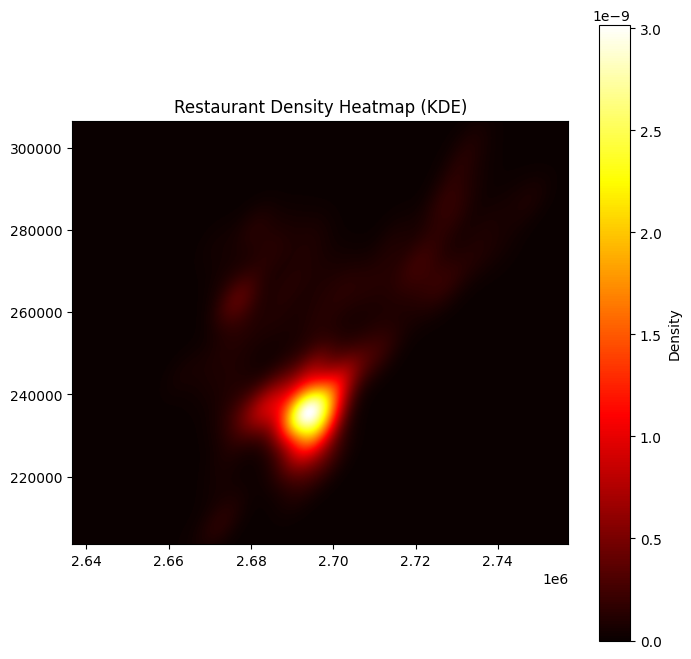

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# extract coordinates
coords = np.vstack([yelp_2272.geometry.x, yelp_2272.geometry.y])
kde = gaussian_kde(coords)

# evaluate KDE on grid
xmin, ymin, xmax, ymax = yelp_2272.total_bounds
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kde_values = kde(positions).reshape(xx.shape)

plt.figure(figsize=(8,8))
plt.imshow(kde_values.T, origin='lower', cmap="hot", extent=[xmin, xmax, ymin, ymax])
plt.title("Restaurant Density Heatmap (KDE)")
plt.colorbar(label="Density")
plt.show()



#### K-means clusters - Ignore this version Use Yelp Notebook one

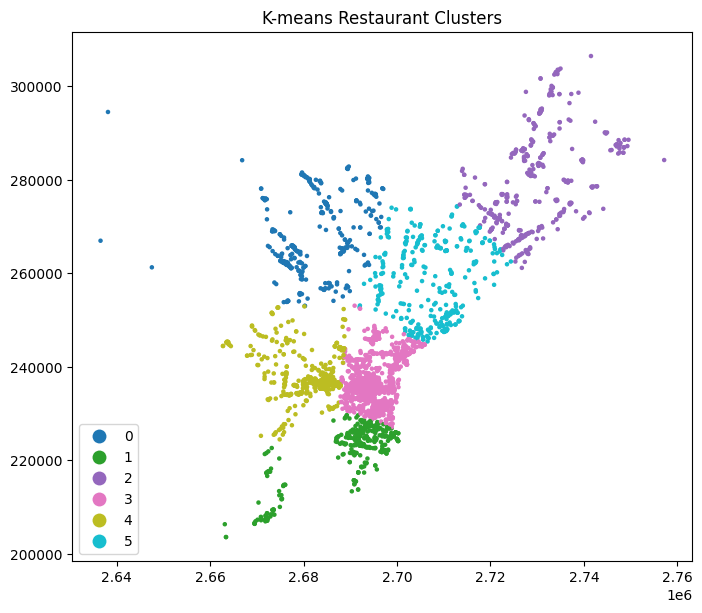

In [ ]:
from sklearn.cluster import KMeans

coords = np.column_stack([yelp_2272.geometry.x, yelp_2272.geometry.y])

kmeans = KMeans(n_clusters=6, random_state=42).fit(coords)
yelp_2272["cluster"] = kmeans.labels_

# Plot clusters
fig, ax = plt.subplots(figsize=(8,8))
yelp_2272.plot(column="cluster", categorical=True, legend=True, markersize=5, ax=ax)
plt.title("K-means Restaurant Clusters")
plt.show()


#### Hotspot grids (Fishnet)

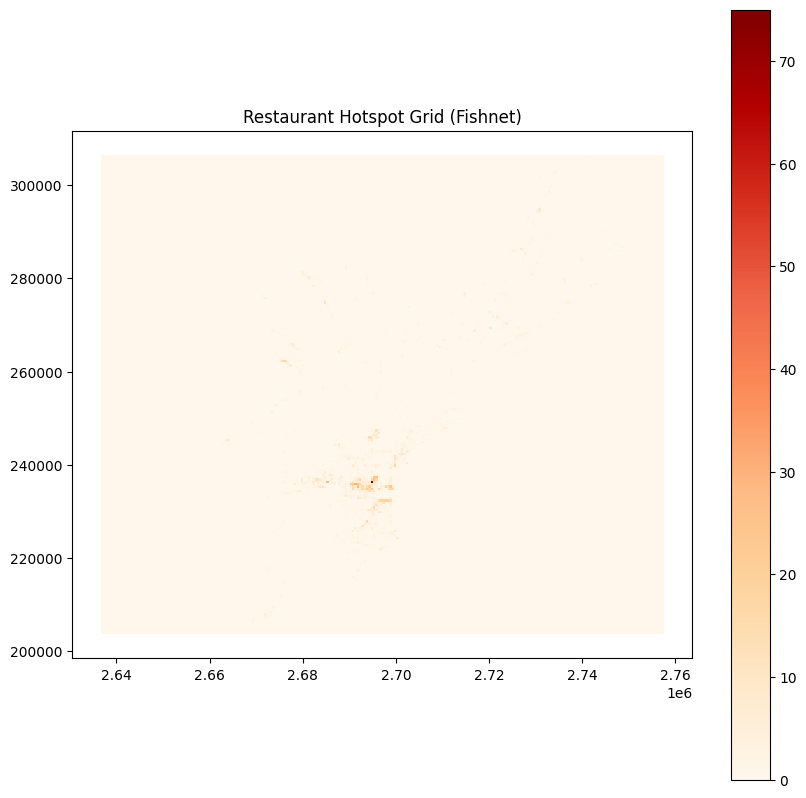

In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# 1. Create fishnet grid
xmin, ymin, xmax, ymax = yelp_2272.total_bounds
grid_size = 500  # meters

cols = np.arange(xmin, xmax + grid_size, grid_size)
rows = np.arange(ymin, ymax + grid_size, grid_size)

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+grid_size,y), (x+grid_size,y+grid_size), (x,y+grid_size)]))

fishnet = gpd.GeoDataFrame({"geometry": polygons}, crs="EPSG:2272")

# 2. Give fishnet a stable index so joins ALWAYS work
fishnet = fishnet.reset_index().rename(columns={"index": "fishnet_id"})

# 3. Spatial join (inner = only matches)
joined = gpd.sjoin(yelp_2272, fishnet, how="inner", predicate="within")

# 4. Count restaurants per grid cell
heat = joined.groupby("fishnet_id").size()

# 5. Merge counts back into fishnet
fishnet["count"] = fishnet["fishnet_id"].map(heat).fillna(0)

# 6. Plot grid
fig, ax = plt.subplots(figsize=(10,10))
fishnet.plot(column="count", cmap="OrRd", legend=True, ax=ax)
plt.title("Restaurant Hotspot Grid (Fishnet)")
plt.show()

### Top 10 by review:

In [ ]:
philly = merged[merged["city"].str.lower() == "philadelphia"].copy()
df_top10 = philly.nlargest(10, "review_count")[[
    "name_left", "latitude", "longitude", "review_count"
]].copy()

df_top10.rename(columns={"name_left": "name"}, inplace=True)

df_top10


,name,latitude,longitude,review_count
4597,Parc,39.949172,-75.170727,2761
12195,Jim's South St,39.941498,-75.149272,2736
34284,Green Eggs Café,39.948123,-75.162463,2679
25910,Tommy DiNic's,39.953478,-75.159396,2221
25910,Tommy DiNic's,39.953478,-75.159396,2221
25079,Nan Zhou Hand Drawn Noodle House,39.955401,-75.156901,2188
6940,Sonny's Famous Steaks,39.949918,-75.144792,1697
29639,Buddakan,39.948919,-75.147167,1561
2416,Village Whiskey,39.951417,-75.173768,1553
33908,Vedge,39.947931,-75.161428,1447


## Folium Interactive Map

In [ ]:
import folium

max_size = 40
min_size = 8

df_top10["marker_size"] = (
    (df_top10["review_count"] - df_top10["review_count"].min()) /
    (df_top10["review_count"].max() - df_top10["review_count"].min())
) * (max_size - min_size) + min_size

m = folium.Map(
    location=[39.9526, -75.1652],
    zoom_start=12,
    tiles="CartoDB positron"
)

for _, row in df_top10.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=row["marker_size"],
        color="#3186cc",
        fill=True,
        fill_opacity=0.55,
        popup=f"{row['name']}<br>Reviews: {row['review_count']}"
    ).add_to(m)

title_html = '''
<h3 align="center" style="font-size:20px"><b>Philadelphia: Top 10 Yelp Hotspots (by Review Count)</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

m

## Static Map

In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 90.3 MB/s eta 0:00:00


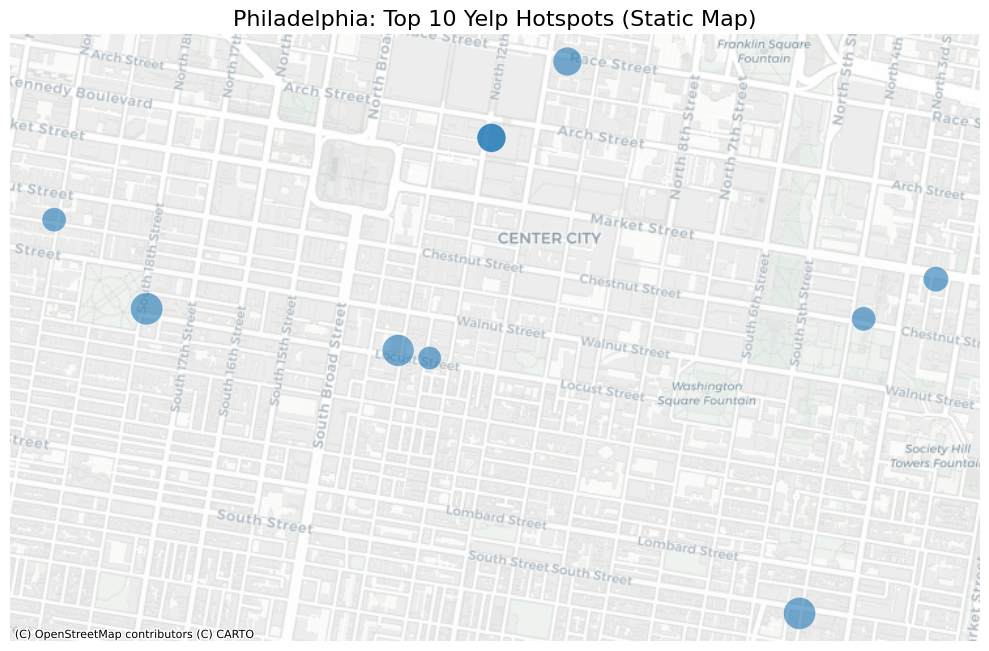

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert df_top10 to geodataframe
gdf = gpd.GeoDataFrame(
    df_top10,
    geometry=gpd.points_from_xy(df_top10.longitude, df_top10.latitude),
    crs="EPSG:4326"
).to_crs(3857)   # convert to web mercator for tiles

fig, ax = plt.subplots(figsize=(10, 10))

# Plot points scaled by review count
gdf.plot(
    ax=ax,
    markersize=gdf["review_count"] / 5,  # tune scaling
    color="#1f78b4",
    alpha=0.6,
    edgecolor="white",
    linewidth=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Philadelphia: Top 10 Yelp Hotspots (Static Map)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("philly_hotspots.png", dpi=300)
plt.show()


## Yelps star reviews Map

In [ ]:
gdf_all = gpd.GeoDataFrame(
    philly,
    geometry=gpd.points_from_xy(philly.longitude, philly.latitude),
    crs="EPSG:4326"
).to_crs(3857)

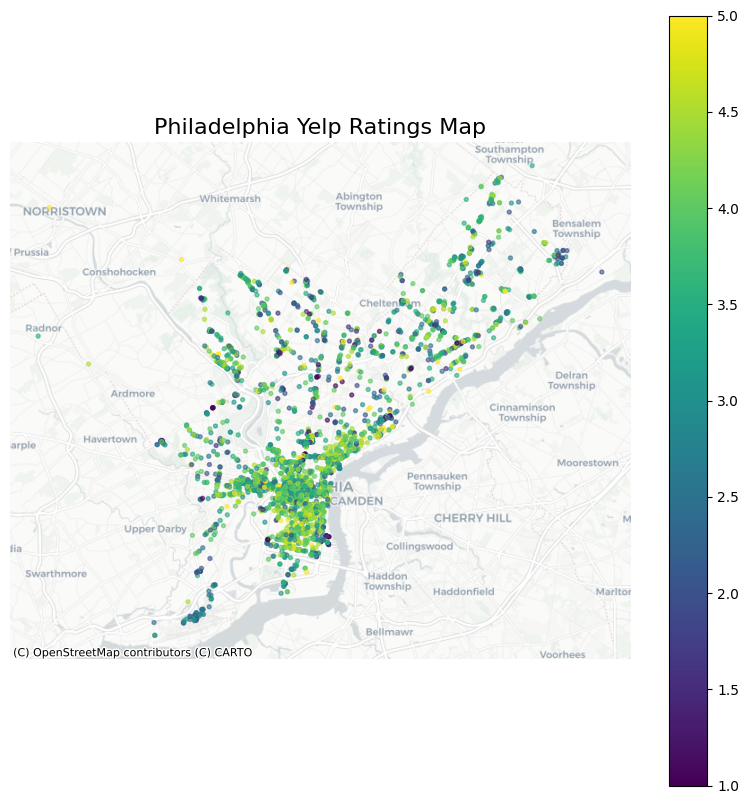

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_all.plot(
    ax=ax,
    column="stars",
    cmap="viridis",
    markersize=8,
    legend=True,
    alpha=0.6
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Philadelphia Yelp Ratings Map", fontsize=16)
ax.set_axis_off()
plt.savefig("yelp_stars_map.png", dpi=300)
plt.show()
